# Diyabet Verisetinde Feature Engineering

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install missingno
import missingno as msno
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler

## Keşifci Veri Analizi

### Genel Resim İnceleme

In [5]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Numeric ve Kategorik Değişkenleri Yakalama

In [9]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [10]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [11]:
cat_cols

['Outcome']

In [12]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [13]:
cat_but_car

[]

### Numerik ve Kategorik Değişkenlerin Analizi

In [15]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

In [16]:
for col in num_cols:
    num_summary(df, col)
    print("\n************************\n")

count    768.000000
mean       3.845052
std        3.369578
min        0.000000
5%         0.000000
10%        0.000000
20%        1.000000
30%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
70%        5.000000
80%        7.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: Pregnancies, dtype: float64

************************

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
5%        79.000000
10%       85.000000
20%       95.000000
30%      102.000000
40%      109.000000
50%      117.000000
60%      125.000000
70%      134.000000
80%      147.000000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: Glucose, dtype: float64

************************

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
5%        38.700000
10%       54.000000
20%       60.000000
30%       64.000000
40%       68.000000
50%       72.000000
60

### Hedef Değişken Analizi

In [18]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0           3.298000
1           4.865672


            Glucose
Outcome            
0        109.980000
1        141.257463


         BloodPressure
Outcome               
0            68.184000
1            70.824627


         SkinThickness
Outcome               
0            19.664000
1            22.164179


            Insulin
Outcome            
0         68.792000
1        100.335821


               BMI
Outcome           
0        30.304200
1        35.142537


         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500


               Age
Outcome           
0        31.190000
1        37.067164




### Aykırı Gözlem Analizi

In [20]:
def outlier_thresholds(dataframe, col, lower_quantile = 0.05, upper_quantile = 0.95):
    q1 = df[col].quantile(lower_quantile)
    q3 = df[col].quantile(upper_quantile)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    up = q3 + 1.5 * iqr

    return low, up

def check_outlier_thresholds(dataframe, col, lower_quantile = 0.05, upper_quantile = 0.95):
    low, up = outlier_thresholds(dataframe, col, lower_quantile, upper_quantile)

    if dataframe[(dataframe[col] > up) | (dataframe[col] < low)].any(axis=None):
        return True
    else:
        return False

In [21]:
for col in num_cols:
    print("\n*******" , col , "**********")
    print(check_outlier_thresholds(df, col))


******* Pregnancies **********
False

******* Glucose **********
False

******* BloodPressure **********
False

******* SkinThickness **********
False

******* Insulin **********
True

******* BMI **********
False

******* DiabetesPedigreeFunction **********
False

******* Age **********
False


### Eksik Gözlem Analizi

In [23]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [24]:
for col in df.columns:
    if df[df[col] == 0].any(axis=None):
        print(col)

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
Outcome


In [25]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if (dataframe[col] == 0).sum() > 0]

    n_miss = (dataframe[na_columns] == 0).sum().sort_values(ascending=False)
    ratio = ((dataframe[na_columns] == 0).sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [26]:
missing_values_table(df)

               n_miss  ratio
Outcome           500  65.10
Insulin           374  48.70
SkinThickness     227  29.56
Pregnancies       111  14.45
BloodPressure      35   4.56
BMI                11   1.43
Glucose             5   0.65


### Korelasyon Analizi

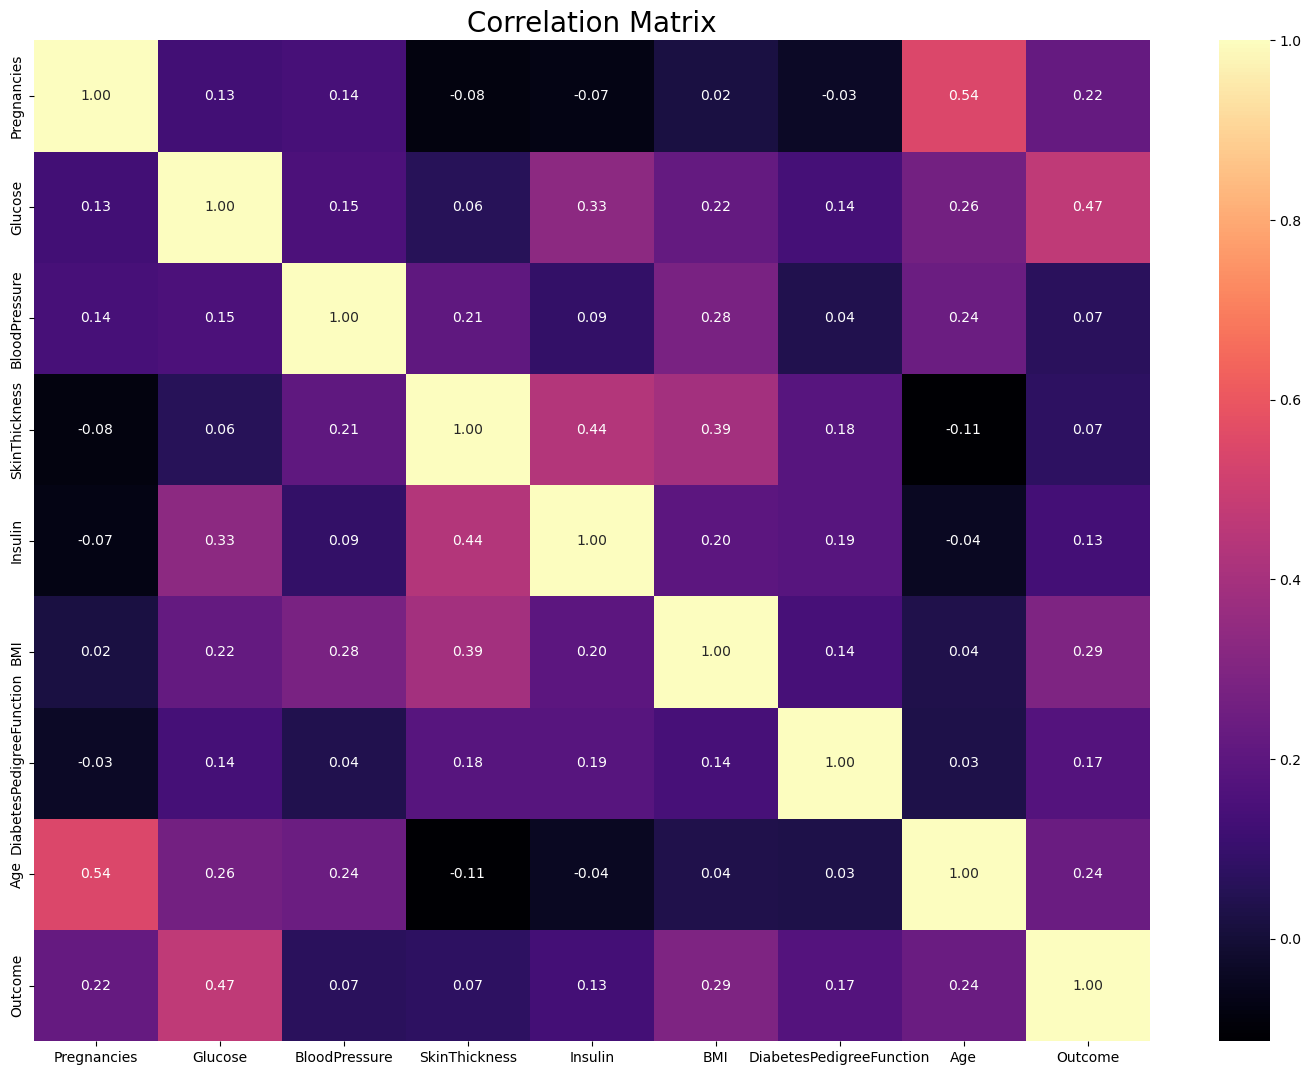

In [28]:
df.corr()

# Korelasyon Matrisi
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show(block=True)

## Base Model Kurulumu

In [30]:
y = df["Outcome"]
X = df.drop("Outcome", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.77
Recall: 0.706
Precision: 0.59
F1: 0.64
Auc: 0.75


### FEATURE IMPORTANCE

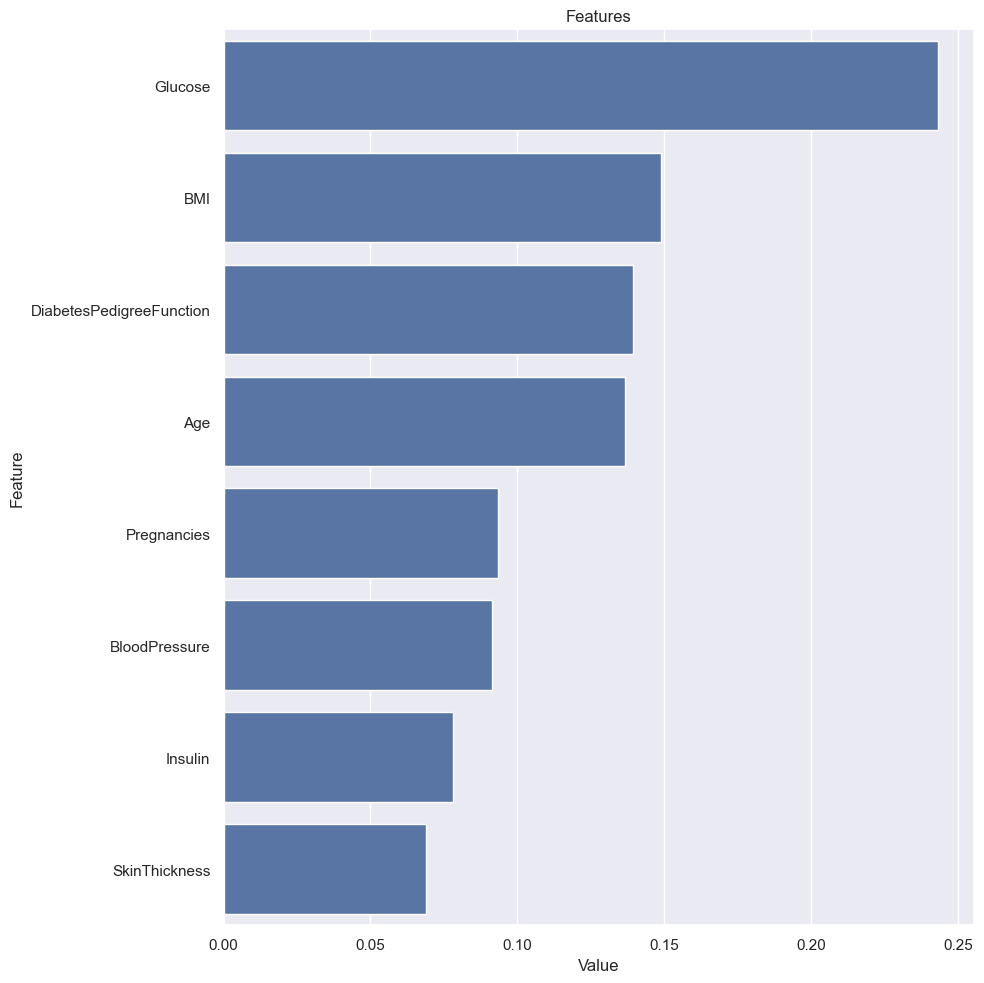

In [32]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)

## Feature Engineering

### Eksik Değer Analizi

In [35]:
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]

for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

In [36]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [37]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

na_columns = missing_values_table(df, na_name=True)

               n_miss  ratio
Insulin           374  48.70
SkinThickness     227  29.56
BloodPressure      35   4.56
BMI                11   1.43
Glucose             5   0.65


In [38]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


missing_vs_target(df, "Outcome", na_columns)

                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                   0.348624    763
1                   0.400000      5


                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                         0.343793    733
1                         0.457143     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                         0.332717    541
1                         0.387665    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                   0.329949    394
1                   0.368984    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0               0.351387    757
1               0.181818     11




In [39]:
for col in zero_columns:
    df.loc[df[col].isnull(), col] = df[col].median()

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [40]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### Aykırı Değer Analizi

In [42]:
def replace_with_thresholds(dataframe, variable, lower_quantile = 0.05, upper_quantile = 0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, lower_quantile, upper_quantile)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [43]:
for col in df.columns:
    print(col, check_outlier_thresholds(df, col))
    if check_outlier_thresholds(df, col):
        replace_with_thresholds(df, col)

print("\n***********************\n")
for col in df.columns:
    print(col, check_outlier_thresholds(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False

***********************

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


### ÖZELLİK ÇIKARIMI

In [45]:
df['Glucose*Insulin'] = df['Glucose'] * df['Insulin']

In [46]:
df['Glucose+Insulin'] = df['Glucose'] + df['Insulin']

In [47]:
df['Pregnancies*Glucose'] = (1 + df['Pregnancies']) * df['Glucose']

In [48]:
df['Pregnancies*Insulin'] = (1 + df['Pregnancies']) * df['Insulin']

In [49]:
df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 50), "NEW_AGE_CAT"] = "senior"

In [50]:
df['NEW_BMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],labels=["Underweight", "Healthy", "Overweight", "Obese"])

In [51]:
df.loc[(df["Glucose"] < 70) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "lowmature"
df.loc[(df["Glucose"] < 70) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "lowsenior"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normalmature"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normalsenior"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hiddenmature"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hiddensenior"
df.loc[(df["Glucose"] > 125) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "highmature"
df.loc[(df["Glucose"] > 125) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "highsenior"

In [52]:
df.columns = [col.upper() for col in df.columns]

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,GLUCOSE*INSULIN,GLUCOSE+INSULIN,PREGNANCIES*GLUCOSE,PREGNANCIES*INSULIN,NEW_AGE_CAT,NEW_BMI,NEW_AGE_GLUCOSE_NOM
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1,18500.0,273.0,1036.0,875.0,senior,Obese,highsenior
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0,10625.0,210.0,170.0,250.0,mature,Overweight,normalmature
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1,22875.0,308.0,1647.0,1125.0,mature,Healthy,highmature
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,8366.0,183.0,178.0,188.0,mature,Overweight,normalmature
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,23016.0,305.0,137.0,168.0,mature,Obese,highmature


### Encoding

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   PREGNANCIES               768 non-null    int64   
 1   GLUCOSE                   768 non-null    float64 
 2   BLOODPRESSURE             768 non-null    float64 
 3   SKINTHICKNESS             768 non-null    float64 
 4   INSULIN                   768 non-null    float64 
 5   BMI                       768 non-null    float64 
 6   DIABETESPEDIGREEFUNCTION  768 non-null    float64 
 7   AGE                       768 non-null    int64   
 8   OUTCOME                   768 non-null    int64   
 9   GLUCOSE*INSULIN           768 non-null    float64 
 10  GLUCOSE+INSULIN           768 non-null    float64 
 11  PREGNANCIES*GLUCOSE       768 non-null    float64 
 12  PREGNANCIES*INSULIN       768 non-null    float64 
 13  NEW_AGE_CAT               768 non-null    object  

In [55]:
df = pd.get_dummies(df, drop_first=True)

In [56]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,GLUCOSE*INSULIN,...,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1,18500.0,...,False,False,True,False,False,True,False,False,False,False
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0,10625.0,...,False,True,False,False,False,False,False,False,True,False
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1,22875.0,...,True,False,False,False,True,False,False,False,False,False
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,8366.0,...,False,True,False,False,False,False,False,False,True,False
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,23016.0,...,False,False,True,False,True,False,False,False,False,False


In [57]:
bool_cols = [col for col in df.columns if df[col].dtype == "bool"]
bool_cols

['NEW_AGE_CAT_senior',
 'NEW_BMI_Healthy',
 'NEW_BMI_Overweight',
 'NEW_BMI_Obese',
 'NEW_AGE_GLUCOSE_NOM_hiddensenior',
 'NEW_AGE_GLUCOSE_NOM_highmature',
 'NEW_AGE_GLUCOSE_NOM_highsenior',
 'NEW_AGE_GLUCOSE_NOM_lowmature',
 'NEW_AGE_GLUCOSE_NOM_lowsenior',
 'NEW_AGE_GLUCOSE_NOM_normalmature',
 'NEW_AGE_GLUCOSE_NOM_normalsenior']

In [58]:
df[bool_cols] = df[bool_cols].astype(int)
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,GLUCOSE*INSULIN,...,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1,18500.0,...,0,0,1,0,0,1,0,0,0,0
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0,10625.0,...,0,1,0,0,0,0,0,0,1,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1,22875.0,...,1,0,0,0,1,0,0,0,0,0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,8366.0,...,0,1,0,0,0,0,0,0,1,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,23016.0,...,0,0,1,0,1,0,0,0,0,0


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   PREGNANCIES                       768 non-null    int64  
 1   GLUCOSE                           768 non-null    float64
 2   BLOODPRESSURE                     768 non-null    float64
 3   SKINTHICKNESS                     768 non-null    float64
 4   INSULIN                           768 non-null    float64
 5   BMI                               768 non-null    float64
 6   DIABETESPEDIGREEFUNCTION          768 non-null    float64
 7   AGE                               768 non-null    int64  
 8   OUTCOME                           768 non-null    int64  
 9   GLUCOSE*INSULIN                   768 non-null    float64
 10  GLUCOSE+INSULIN                   768 non-null    float64
 11  PREGNANCIES*GLUCOSE               768 non-null    float64
 12  PREGNANC

### Scaling

In [61]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 24
cat_cols: 12
num_cols: 12
cat_but_car: 0
num_but_cat: 12


In [62]:
num_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE',
 'GLUCOSE*INSULIN',
 'GLUCOSE+INSULIN',
 'PREGNANCIES*GLUCOSE',
 'PREGNANCIES*INSULIN']

In [63]:
rs = RobustScaler()
df[num_cols] = rs.fit_transform(df[num_cols])
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,GLUCOSE*INSULIN,...,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior
0,0.6,0.765432,0.000,0.857143,0.000000,0.142857,0.665359,1.235294,1,0.436620,...,0,0,1,0,0,1,0,0,0,0
1,-0.4,-0.790123,-0.375,0.000000,0.000000,-0.626374,-0.056209,0.117647,0,-0.450704,...,0,1,0,0,0,0,0,0,1,0
2,1.0,1.629630,-0.500,0.000000,0.000000,-0.989011,0.783007,0.176471,1,0.929577,...,1,0,0,0,1,0,0,0,0,0
3,-0.4,-0.691358,-0.375,-0.857143,-5.391304,-0.461538,-0.537255,-0.470588,0,-0.705239,...,0,1,0,0,0,0,0,0,1,0
4,-0.6,0.493827,-2.000,0.857143,7.478261,1.186813,5.007843,0.235294,1,0.945465,...,0,0,1,0,1,0,0,0,0,0


In [64]:
df.shape

(768, 24)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   PREGNANCIES                       768 non-null    float64
 1   GLUCOSE                           768 non-null    float64
 2   BLOODPRESSURE                     768 non-null    float64
 3   SKINTHICKNESS                     768 non-null    float64
 4   INSULIN                           768 non-null    float64
 5   BMI                               768 non-null    float64
 6   DIABETESPEDIGREEFUNCTION          768 non-null    float64
 7   AGE                               768 non-null    float64
 8   OUTCOME                           768 non-null    int64  
 9   GLUCOSE*INSULIN                   768 non-null    float64
 10  GLUCOSE+INSULIN                   768 non-null    float64
 11  PREGNANCIES*GLUCOSE               768 non-null    float64
 12  PREGNANC

## Nihai Modelleme

In [67]:
y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.78
Recall: 0.78
Precision: 0.56
F1: 0.65
Auc: 0.78


In [68]:
# Base Model
# Accuracy: 0.77 (TP+TN)/(TP+TN+FP+FN)
# Recall: 0.706 # pozitif sınıfın ne kadar başarılı tahmin edildiği TP/(TP+FN)
# Precision: 0.59 # Pozitif sınıf olarak tahmin edilen değerlerin başarısı  TP/(TP+FP)
# F1: 0.64  2 * ( Precision*Recall ) / ( Precision+Recall )
# Auc: 0.75

### FEATURE IMPORTANCE

       Value                           Feature
1   0.129052                           GLUCOSE
8   0.105579                   GLUCOSE*INSULIN
10  0.092383               PREGNANCIES*GLUCOSE
9   0.091870                   GLUCOSE+INSULIN
7   0.090379                               AGE
5   0.087887                               BMI
6   0.081876          DIABETESPEDIGREEFUNCTION
11  0.062532               PREGNANCIES*INSULIN
2   0.051396                     BLOODPRESSURE
3   0.047704                     SKINTHICKNESS
4   0.039292                           INSULIN
0   0.037727                       PREGNANCIES
17  0.023693    NEW_AGE_GLUCOSE_NOM_highmature
15  0.013705                     NEW_BMI_Obese
21  0.012478  NEW_AGE_GLUCOSE_NOM_normalmature
14  0.009357                NEW_BMI_Overweight
13  0.008373                   NEW_BMI_Healthy
12  0.007375                NEW_AGE_CAT_senior
16  0.002924  NEW_AGE_GLUCOSE_NOM_hiddensenior
18  0.002588    NEW_AGE_GLUCOSE_NOM_highsenior
22  0.001700 

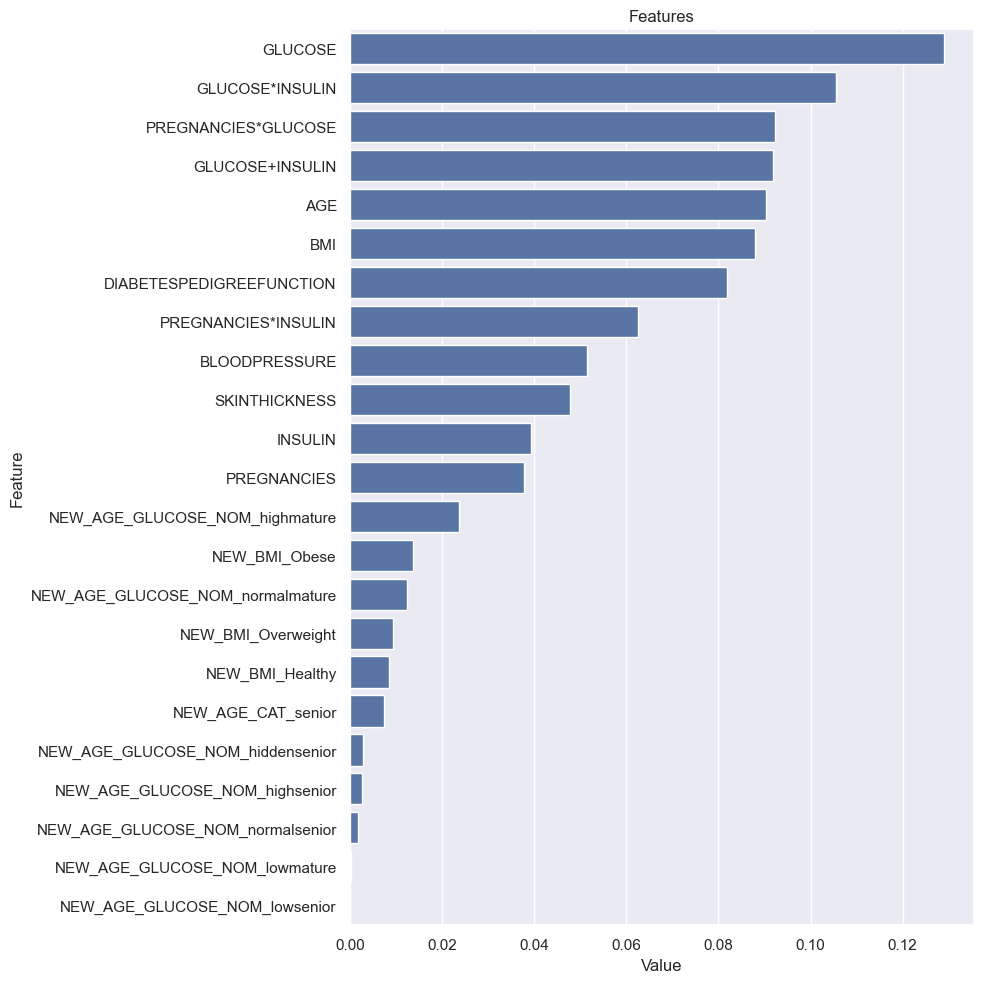

In [70]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)